Revisit simulations from Parts 1 and 2, now considering the channel model
which includes the fast fading e§ect. Consider a baseline system conÖguration with
$M = 64$, $K = 13$ and $N = 2$ (do not consider any special radio resource management
function such as advanced UE-AP attachment, channel allocation or power control).
Simulate your system with each of three channel models from Part 1 (distance dependent
path gain only), from Part 2 (the model from Part 1 plus shadowing), and the total
path gain model from this Part including fast fading. Notice the variation in the per-UE channel capacity $10th$ and $50-th$ percentiles as you go from the simple to the more
complete channel model. By adjusting (reducing) the demand (number of UEs, K) is it
possible to restore the QoS target (spectrum efficiency of 1 $bps/Hz$ at cell border) with fast fading? Discuss the implications with your advisor.


In [87]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12)

In [88]:
# Função que transforma Linear para dB
def lin2db(x):
    return 10 * np.log10(x)

# Função que transforma dB para Linear
def db2lin(x):
    return 10 ** (x / 10)

# Função que transforma Linear para dBm
def lin2dbm(x):
    return 10 * np.log10(x) + 30

# Função que transforma dBm para Linear
def dbm2lin(x):
    return 10 ** ((x - 30) / 10)

In [89]:
# Função que define os eixos x e y da CDF
def cdf(dados):
    x = np.sort(dados)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [90]:
# Função que gera as coordenadas dos APs
def distribuir_APs(num_aps, area):
    '''Distributes Access Points (APs) evenly within a square area.
    
    Parameters:
    num_aps (int): The number of APs to distribute. Must be a perfect square.
    area (int): The length of the side of the square area in which to distribute the APs.
    
    Returns:
    np.array: An array of coordinates for the APs, or None if num_aps is not a perfect square.'''
    
    if num_aps not in [1, 4, 9, 16, 25, 36, 49, 64, 100]:
        return None

    tamanho_quadrado = area
    lado_quadrado = int(np.sqrt(num_aps))

    tamanho_celula = tamanho_quadrado // lado_quadrado

    # Criar coordenadas usando meshgrid
    x, y = np.meshgrid(np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula),
                      np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula))

    coordenadas_APs = np.column_stack((x.ravel(), y.ravel()))

    return coordenadas_APs

In [91]:
# Função que gera a distância entre a UE e a AP
def dAPUE(x_coord, y_coord, ap_coord, d_reference=1):
  '''Calculate the Euclidean distance between a user equipment (UE) and an access point (AP).
    
    Parameters:
    ue_coords (tuple): A tuple (x_coord, y_coord) representing the coordinates of the UE.
    ap_coords (np.array): An array containing the coordinates of the APs.
    
    Returns:
    float: The Euclidean distance between the UE and the AP. If the euclidean distance is less than 1, return 1.
  '''
  dAPUE = np.linalg.norm(np.array([x_coord, y_coord]) - ap_coord)
  if dAPUE < d_reference:
    return d_reference
  else:
    return dAPUE

In [92]:
#Função que define o shadowing para cada usuário
def find_shadowing(standard_shadow, ues, aps):
    '''Generate a shadowing value for a user.

    Parameters:
    standard_shadow (float): The standard deviation of the shadowing values.
    ues (int): The number of user equipment (UE) in the simulation.
    aps (int): The number of access points (APs) in the

    Returns:
    np.array: A 2D array of shadowing values for each UE and AP.
    '''

    shadowing = np.random.lognormal(0, standard_shadow, (ues, aps))

    return shadowing 

In [93]:
def find_fastfading(standard_fading, ues, aps, channels):
    '''Função que calcula o fast fading para um dado usuário.
    
    Parâmetros:
    standard_fading (float): O desvio padrão da distribuição normal.
    ues (int): O número de usuários.
    aps (int): O número de pontos de acesso.
    channels (int): O número de canais.
    
    Retorna:
    np.array: Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    '''

    fast_fading = np.sqrt( (standard_fading * np.random.randn(ues, aps, channels))**2 + (standard_fading * np.random.randn(ues, aps, channels))**2 )

    return fast_fading

In [94]:
# Função que calcula o path gain apenas com a distância
def find_path_gain_dist(dist):

    ambiente_const = 1e-4
    pathloss_const = 4


    path_gain_result = ambiente_const / (dist ** pathloss_const)

        
    return path_gain_result 

In [95]:
# Função que calcula o path gain com a distância e o shadowing
def find_path_gain_shadow(dist, shadowing):
    ambiente_const = 1e-4
    pathloss_const = 4


    path_gain_result = shadowing * (ambiente_const / (dist ** pathloss_const))

    return path_gain_result

In [96]:
def find_path_gain_fastfading(dist, shadowing, fastfading):
    ambiente_const = 1e-4
    pathloss_const = 4

    # Número de canais
    num_channels = fastfading.shape[2]

    # Expandindo o shadowing e o dist para ter a mesma forma que o fastfading
    shadowing_expanded = np.repeat(shadowing[:, :, np.newaxis], num_channels, axis=2)  # Agora tem forma (ues, aps, num_channels)
    dist_expanded = np.repeat((dist ** pathloss_const)[:, :, np.newaxis], num_channels, axis=2)  # Agora tem forma (ues, aps, num_channels)

    # Calculando o path gain
    path_gain_result = (shadowing_expanded * (ambiente_const / dist_expanded)) * (fastfading ** 2)

    return path_gain_result


In [97]:
def calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, p_t, pathgain_index, area):
    '''Função que calcula a SINR para múltiplos UEs e APs em diferentes canais.

    i-th AP, j-th UE, c-th channel
    
    Nesse algoritimo as linhas são os UEs e as colunas são os APs. Portanto, para acessar usamos [j][i][c].
    
    Parâmetros:
    banda (float): Largura de banda total.
    K_0 (float): Constante de ruído.
    aps (int): Número de APs.
    ues (int): Número de UEs.
    channels (int): Número de canais.
    sigma_shadowing (float): Desvio padrão para o shadowing.
    sigma_fastfading (float): Desvio padrão para o fast fading.
    p_t (float): Potência de transmissão.
    pathgain_index (int): Índice para o tipo de ganho de caminho a ser utilizado.
    area (float): Área de distribuição dos APs.
    
    Retorna:
    np.array: O valor do SINR para cada UE.
    '''
    x_coord, y_coord, aps_position = np.zeros(ues), np.zeros(ues), distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))
    shadowing = find_shadowing(sigma_shadowing, ues, aps)
    fastfading = find_fastfading(sigma_fastfading, ues, aps, channels)
    power_trans = np.ones(ues)*p_t
    power_noise = np.ones(ues)*(K_0 * banda / channels)

    # Inicializações
    # Coordenadas dos UEs
    for j in range (ues):
        x_coord[j] = np.random.randint(0, area)
        y_coord[j] = np.random.randint(0, area)

    # Distância entre UEs e APs
    for j in range (ues):
        for i in range (aps):
            dist[j][i] = dAPUE(x_coord[j], y_coord[j], aps_position[i])

    # Cálculo do path gain

    # Apenas distância
    if pathgain_index == 0: 
        path_gain = find_path_gain_dist(dist)
        # Cálculo da potência recebida
        sinr_total = np.zeros(path_gain.shape)
        sinr_ue = np.zeros(path_gain.shape[0])  
        for i in range(path_gain.shape[1]):
            power_recived_sum = 0
            for j in range(path_gain.shape[0]):
                power_recived_sum += np.abs(path_gain[j][i]) * power_trans[j]
            for j in range(path_gain.shape[0]):
                power_recived = np.abs(path_gain[j][i]) * power_trans[j]

                # SINR
                # É feita essa subtração para não somar a potência recebida do próprio usuário, ficando apenas a potência recebida dos outros usuários refernte a interferência
                sinr_total[j][i] = power_recived / ((power_recived_sum - power_recived) + power_noise[j])
        
        # Como eu tenho uma array 2D que define a SINR de cada UE para cada AP, eu preciso pegar o maior valor de cada linha, pois será referente a maior SINR de cada usuário.

        for j in range(sinr_total.shape[0]):
            sinr_ue[j] = np.max(sinr_total[j])
#################################################################################################################################################
    # Distância e shadowing
    elif pathgain_index == 1: 
        path_gain = find_path_gain_shadow(dist, shadowing)
        sinr_total = np.zeros(path_gain.shape)
        sinr_ue = np.zeros(path_gain.shape[0])
        # Cálculo da potência recebida
        sinr_total = np.zeros(path_gain.shape)
        sinr_ue = np.zeros(path_gain.shape[0])  
        for i in range(path_gain.shape[1]):
            power_recived_sum = 0
            for j in range(path_gain.shape[0]):
                power_recived_sum += np.abs(path_gain[j][i]) * power_trans[j]
            for j in range(path_gain.shape[0]):
                power_recived = np.abs(path_gain[j][i]) * power_trans[j]

                # SINR
                # É feita essa subtração para não somar a potência recebida do próprio usuário, ficando apenas a potência recebida dos outros usuários refernte a interferência
                sinr_total[j][i] = power_recived / ((power_recived_sum - power_recived) + power_noise[j])
        
        # Como eu tenho uma array 2D que define a SINR de cada UE para cada AP, eu preciso pegar o maior valor de cada linha, pois será referente a maior SINR de cada usuário.

        for j in range(sinr_total.shape[0]):
            sinr_ue[j] = np.max(sinr_total[j])
#################################################################################################################################################
    # Distância, shadowing e fast fading
    elif pathgain_index == 2:
        path_gain = find_path_gain_fastfading(dist, shadowing, fastfading)
        sinr_total = np.zeros(path_gain.shape)
        sinr_ue = np.zeros(path_gain.shape[0])
        # Cálculo da potência recebida 
        for i in range(path_gain.shape[1]):
            power_recived_sum = 0
            for j in range(path_gain.shape[0]):
                power_recived_sum += (path_gain[j][i]) * power_trans[j]
            for j in range(path_gain.shape[0]):
                power_recived = (path_gain[j][i]) * power_trans[j]

                # SINR
                # É feita essa subtração para não somar a potência recebida do próprio usuário, ficando apenas a potência recebida dos outros usuários refernte a interferência
                sinr_total[j][i] = power_recived / ((power_recived_sum - power_recived) + power_noise[j])
        
        # Como eu tenho uma array 2D que define a SINR de cada UE para cada AP, eu preciso pegar o maior valor de cada linha, pois será referente a maior SINR de cada usuário.

        for j in range(sinr_total.shape[0]):
            sinr_ue[j] = np.max(sinr_total[j])

    return sinr_ue

In [98]:
def find_capacity(sinr, banda):
    '''Função que calcula a capacidade de um dado canal.
    
    Parâmetros:
    sinr (list): A relação sinal ruído mais interferência.
    banda (int): A largura de banda do canal.    
    Retorna:
    list: A capacidade do canal.'''
    
    capacity = banda * np.log2(1 + sinr)
    
    return capacity

In [99]:
bandwidth , transmit_power, d_min, K_0 = 100e6, 1, 1, 1e-20 # Em MHz, mW, metros, mW/Hz respectivamente
aps, ues, channels = 64, 13, 1
area = 1000
sigma_shadowing = 2
sigma_fastfading = 1
dist, shad, fastf = 0, 1, 2 # Distância, Shadowing, Fast Fading


In [100]:
capacity_acum_dist = np.array([])
capacity_acum_shad = np.array([])
capacity_acum_fast = np.array([])

sinr_acum_dist = np.array([])
sinr_acum_shad = np.array([])
sinr_acum_fast = np.array([])

for i in range (1000):
    sinr_dist = calculate_sinr(bandwidth, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, transmit_power, dist, area)
    sinr_shad = calculate_sinr(bandwidth, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, transmit_power, shad, area)
    sinr_fast = calculate_sinr(bandwidth, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, transmit_power, fastf, area)

    capacity_dist = find_capacity(sinr_dist, bandwidth)
    capacity_shad = find_capacity(sinr_shad, bandwidth)
    capacity_fast = find_capacity(sinr_fast, bandwidth)

    sinr_acum_dist = np.append(sinr_acum_dist, sinr_dist)
    sinr_acum_shad = np.append(sinr_acum_shad, sinr_shad)
    sinr_acum_fast = np.append(sinr_acum_fast, sinr_fast)

    capacity_acum_dist = np.append(capacity_acum_dist, capacity_dist)
    capacity_acum_shad = np.append(capacity_acum_shad, capacity_shad)
    capacity_acum_fast = np.append(capacity_acum_fast, capacity_fast)


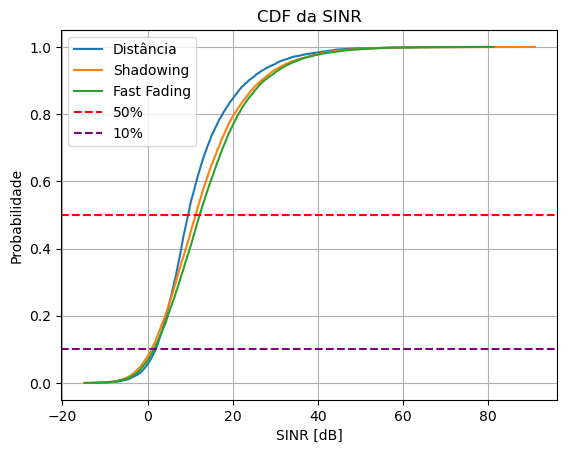

In [101]:
cdf_sinr_dist = cdf(lin2db(sinr_acum_dist))
cdf_sinr_shad = cdf(lin2db(sinr_acum_shad))
cdf_sinr_fast = cdf(lin2db(sinr_acum_fast))

cdf_capacity_dist = cdf(capacity_acum_dist)
cdf_capacity_shad = cdf(capacity_acum_shad)
cdf_capacity_fast = cdf(capacity_acum_fast)

plt.figure()
plt.plot(cdf_sinr_dist[0], cdf_sinr_dist[1], label='Distância')
plt.plot(cdf_sinr_shad[0], cdf_sinr_shad[1], label='Shadowing')
plt.plot(cdf_sinr_fast[0], cdf_sinr_fast[1], label='Fast Fading')
plt.title('CDF da SINR')
plt.xlabel('SINR [dB]')
plt.ylabel('Probabilidade')

plt.axhline(0.5, color='r', linestyle='--', label='50%')
plt.axhline(0.1, color='purple', linestyle='--', label='10%')

plt.legend()
plt.grid()
plt.savefig('Q2_SINR.pdf')
plt.show()


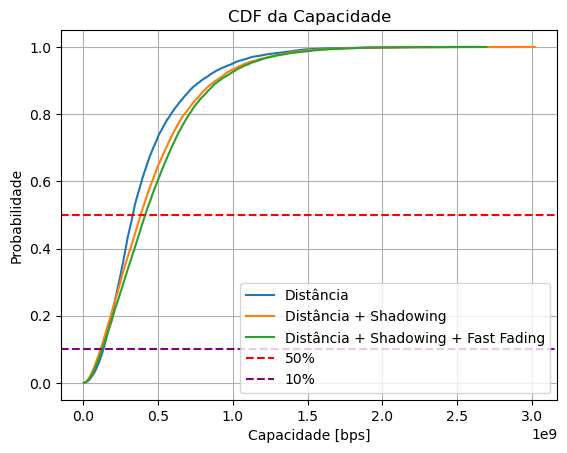

In [102]:
cdf_dist = cdf(capacity_acum_dist)
cdf_shad = cdf(capacity_acum_shad)
cdf_fast = cdf(capacity_acum_fast)

# Plotando a CDF da Capacidade e deixando em Mbps
plt.plot(cdf_dist[0], cdf_dist[1], label='Distância')
plt.plot(cdf_shad[0], cdf_shad[1], label='Distância + Shadowing')
plt.plot(cdf_fast[0], cdf_fast[1], label='Distância + Shadowing + Fast Fading')
plt.title('CDF da Capacidade')
plt.xlabel('Capacidade [bps]')
plt.ylabel('Probabilidade')

plt.axhline(0.5, color='r', linestyle='--', label='50%')
plt.axhline(0.1, color='purple', linestyle='--', label='10%')

plt.legend()
plt.grid()
plt.savefig('Q2_Capacity.pdf')
plt.show()


